In [1]:
pip --version

pip 22.2.2 from C:\Users\Target\anaconda3\lib\site-packages\pip (python 3.9)

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.
autoviz 0.1.806 requires numpy<1.25.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
pip install numpy==1.24.3

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.3 which is incompatible.


# Potato Disease Classification
#### Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [4]:
import tensorflow as tf

In [5]:
import pandas as pd  
import matplotlib.pyplot as plt  
from tensorflow import keras  
from tensorflow.keras import layers, models

In [35]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

## Import data into tensorflow dataset object


In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(  
    "C:/Users/Target/Downloads/archive (1)/PlantVillage",  
    shuffle=True,  
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  
    batch_size=BATCH_SIZE  
) 

Found 2152 files belonging to 3 classes.


In [15]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset)
# 68 *32

68

In [20]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)
    print(label_batch.numpy())

(32, 256, 256, 3)
tf.Tensor([2 1 2 0 1 0 0 1 2 1 0 1 2 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0], shape=(32,), dtype=int32)
[2 1 2 0 1 0 0 1 2 1 0 1 2 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0]


## Visualize some of the images from our dataset


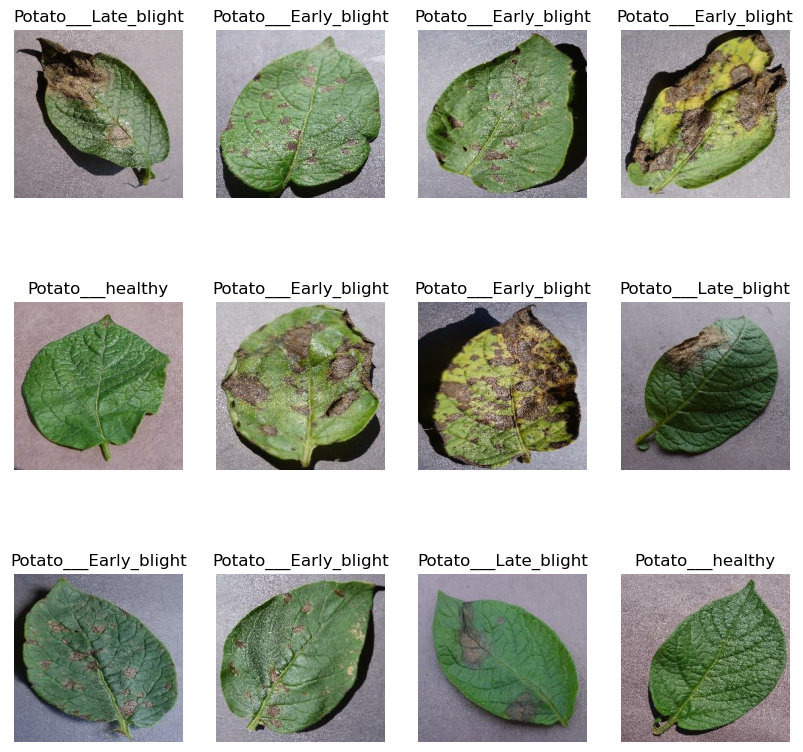

In [34]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)  
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")   

## Function to Split Dataset
 Dataset should be bifurcated into 3 subsets, namely:

   - Training: Dataset to be used while training
   - Validation: Dataset to be tested against while training
   - Test: Dataset to be tested against after we trained a model

In [ ]:
# 80% <== training
# 20% <== 10% validation , 10% test

In [36]:
train_size =.8
len(dataset)*train_size
# 54 batch

54.400000000000006

In [42]:
train_ds = dataset.take(54)
len(train_ds)

54

In [43]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [44]:
val_size =.1
len(dataset)*val_size

6.800000000000001

In [45]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [46]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [47]:
def get_dataset_partitions_tf(ds , train_split=.8,val_split=.1,test_split=.1 ,shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle :
        ds = ds.shuffle(shuffle_size , seed=12)
        
    train_size = int(len(ds)*train_split)
    train_ds = ds.take(train_size)
    val_size = int(len(ds)*val_split)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [51]:
train_ds , val_ds ,test_ds = get_dataset_partitions_tf(dataset)

In [52]:
print('Train size :',len(train_ds))
print('Validation size :',len(val_ds))
print('Test size :',len(test_ds))

Train size : 54
Validation size : 6
Test size : 8


## Cache, Shuffle, and Prefetch the Dataset


In [53]:
# improve performance & run fast
# Caches the dataset in memory after the first iteration, ensuring that subsequent iterations don’t need to reload data from disk.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Pre-Processing
## Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [55]:
resize_rescale = tf.keras.Sequential([  
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  
    layers.Rescaling(1.0 / 255)  
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [59]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [62]:
# archeticture
input_shape = (BATCH_SIZE ,IMAGE_SIZE  , IMAGE_SIZE ,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu' ,input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [65]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [67]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [68]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds  
)
#verbose=1

#This controls the amount of output you see during training.
#Setting verbose=1 means you'll get progress updates after each epoch

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.4481 - loss: 0.9726 - val_accuracy: 0.4635 - val_loss: 0.8561
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5753 - loss: 0.8402 - val_accuracy: 0.7083 - val_loss: 0.7239
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7383 - loss: 0.6369 - val_accuracy: 0.7656 - val_loss: 0.5117
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8135 - loss: 0.4640 - val_accuracy: 0.8490 - val_loss: 0.3789
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8562 - loss: 0.3634 - val_accuracy: 0.7812 - val_loss: 0.4463
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8695 - loss: 0.3127 - val_accuracy: 0.8988 - val_loss: 0.3387
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9048 - loss: 0.2505 - val_accuracy: 0.8646 - val_loss: 0.3759
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9143 - loss: 0.2436 - val_accuracy: 0.9167 - val_lo

In [69]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 681ms/step - accuracy: 0.9899 - loss: 0.0364


#### You can see above that we get 0.989.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

## Plotting the Accuracy and Loss Curves


In [70]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [71]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

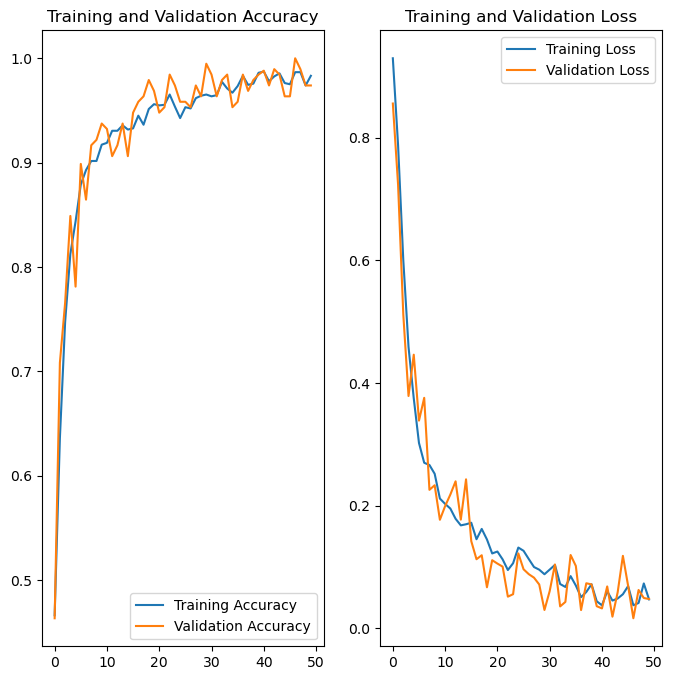

In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image


first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicted label : Potato___Late_blight


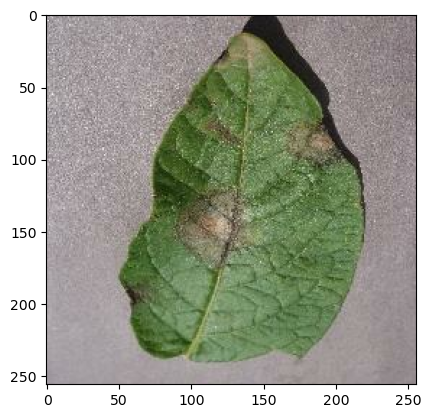

In [80]:
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
   # print(batch_prediction[0])
    print("Predicted label :",class_names[np.argmax(batch_prediction[0])])


## Write a function for inference


In [81]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


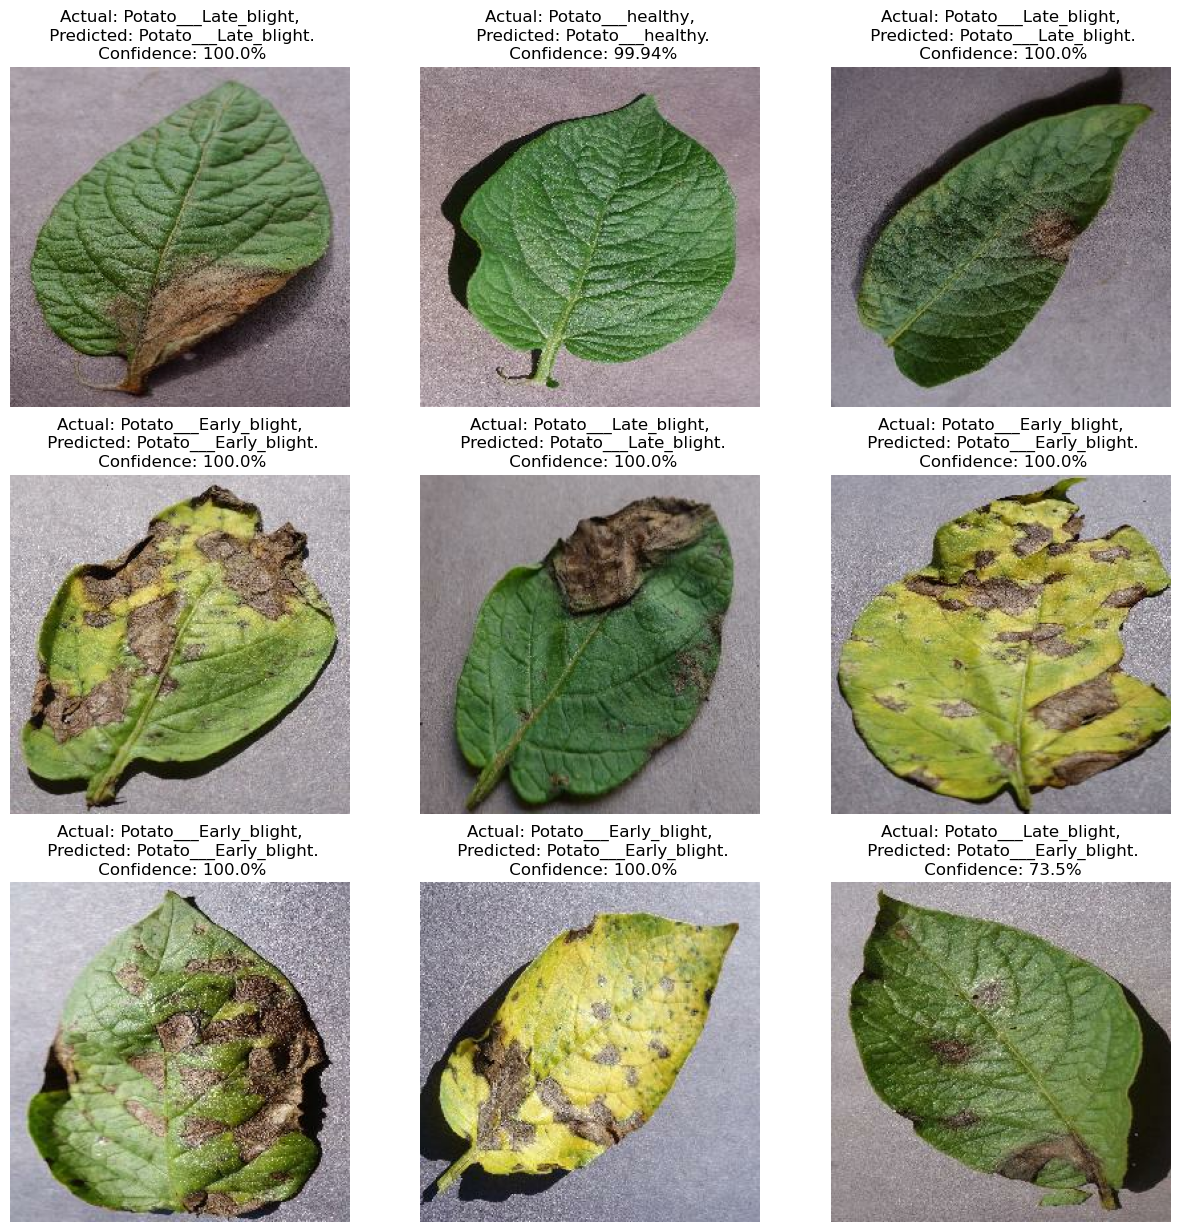

In [82]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model


In [90]:
import os  
# Define the model version  
model_version = 1  
model_dir = "C:/Code/potato-disease/models"  
model_filename = f"model_v{model_version}.h5"  # Choose .keras or .h5 based on your needs  

# Create the complete path  
model_path = os.path.join(model_dir, model_filename)  

# Create the directory if it doesn't exist  
os.makedirs(model_dir, exist_ok=True)  

# Save the model  
model.save(model_path)  

print(f"Model saved at: {model_path}")

Model saved at: C:/Code/potato-disease/models\model_v1.keras


## Convert to TFLight model

In [93]:
import tensorflow as tf  
converter = tf.lite.TFLiteConverter.from_keras_model(model)  
tflite_model = converter.convert()  

with open("model.tflite", 'wb') as f:  
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Target\AppData\Local\Temp\tmp8j_0owtf\assets


INFO:tensorflow:Assets written to: C:\Users\Target\AppData\Local\Temp\tmp8j_0owtf\assets


Saved artifact at 'C:\Users\Target\AppData\Local\Temp\tmp8j_0owtf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(32, 3), dtype=tf.float32, name=None)
Captures:
  2013892787712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892787888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892835808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892835632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892858448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892858272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892860560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892860384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892875008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013892874832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20138928

In [97]:
from IPython.display import FileLink  

# Create a link to download the file  
FileLink(r'model.tflite') 

C:\Users\Target\model.tflite